# Import Modules

In [ ]:
import os
import pathlib
 
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2614, done.
remote: Counting objects: 100% (2614/2614), done.
remote: Compressing objects: 100% (2175/2175), done.
remote: Total 2614 (delta 648), reused 1211 (delta 405), pack-reused 0
Receiving objects: 100% (2614/2614), 32.58 MiB | 34.79 MiB/s, done.
Resolving deltas: 100% (648/648), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1648391 sha256=ad426ea18775ef3223add5fbf26c1697f0d8aff000887dc6b8c89ca8bfa8360c
  Stored in directory: /tmp/pip-ephem-wheel-cache-v78od_72/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=459266c33dd94a8f6e602089ef000e18c674640ab601907dc6f4276daf2f9c77
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=982d653be9f72db7c52b13e068222ef4b08383e789912ab7f706089486648557
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=bace78405145fb7e41b463a31d730751b9f311916172681f9f40

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-05-06 10:28:23.491173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
2021-05-06 10:28:25.781949: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-06 10:28:25.782965: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-06 10:28:25.850275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-06 10:28:25.850963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 d

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
# Put the url of TFRecord dataset

%cd /content
!curl -L "YOUR-TFRECORD-DOWNLOAD-LINK" > dataset.zip; unzip dataset.zip; rm dataset.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   892  100   892    0     0   1664      0 --:--:-- --:--:-- --:--:--  1664
100 26.1M  100 26.1M    0     0  27.8M      0 --:--:-- --:--:-- --:--:--  356M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: train/
 extracting: train/Baby.tfrecord     
 extracting: train/Baby_label_map.pbtxt  


## ※ Split TFRecord file if you need to do

In [ ]:
import tensorflow as tf

def split_tfrecord(tfrecord_path, split_size):
    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:
        ds = tf.data.TFRecordDataset(tfrecord_path).batch(split_size)
        batch = tf.compat.v1.data.make_one_shot_iterator(ds).get_next()
        part_num = 0
        while True:
            try:
                records = sess.run(batch)
                part_path = tfrecord_path + '.{:03d}'.format(part_num)
                with tf.io.TFRecordWriter(part_path) as writer:
                    for record in records:
                        writer.write(record)
                part_num += 1
            except tf.errors.OutOfRangeError: break

In [ ]:
# Split TFRecord and get training set with 1372 image data (70%)

_tfrecord_path = '/content/train/Baby.tfrecord'
_split_size = 1372
split_tfrecord(_tfrecord_path, _split_size)

In [ ]:
# Split TFRecord and get validation set with 392 image data (20%). The last would be test set (10%)

__tfrecord_path = '/content/train/Baby.tfrecord.001'
__split_size = 392
split_tfrecord(__tfrecord_path, __split_size)

## Assign TFRecord dataset

In [ ]:
train_record_fname = '/content/train/Baby.tfrecord.001'
valid_record_fname = '/content/train/Baby.tfrecord.001.000'
test_record_fname = '/content/train/Baby.tfrecord.001.001'
label_map_pbtxt_fname = '/content/train/Baby_label_map.pbtxt'

# Configuration

[TF2 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)


In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
        'batch_size': 12
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'ssd_mobilenet_v2'

num_steps = 40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2021-05-06 10:28:58--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.240, 2607:f8b0:4004:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M   183MB/s    in 0.2s    

2021-05-06 10:28:59 (183 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]



In [ ]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2021-05-06 10:28:59--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4484 (4.4K) [text/plain]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’

ssd_mobilenet_v2_32 100%[===================>]   4.38K  --.-KB/s    in 0s      

2021-05-06 10:29:00 (57.3 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.config’ saved [4484/4484]



In [ ]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=2, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)


In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/models/research/deploy
writing custom configuration file


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

# SSD with Mobilenet v2
# Trained on COCO17, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 22.2 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
 

In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'

## Fine Tuning

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2021-05-06 10:29:00.609642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-06 10:29:02.968867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-06 10:29:02.969710: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-06 10:29:02.975826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-06 10:29:02.976401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-06 10:29:02.976437: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

<IPython.core.display.Javascript object>

## Export a Trained Inference Graph

In [ ]:
#see where our model saved weights
%ls '/content/training/'

checkpoint                   ckpt-39.data-00000-of-00001
ckpt-35.data-00000-of-00001  ckpt-39.index
ckpt-35.index                ckpt-40.data-00000-of-00001
ckpt-36.data-00000-of-00001  ckpt-40.index
ckpt-36.index                ckpt-41.data-00000-of-00001
ckpt-37.data-00000-of-00001  ckpt-41.index
ckpt-37.index                eval/
ckpt-38.data-00000-of-00001  train/
ckpt-38.index


In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-05-04 13:16:19.003172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-04 13:16:21.546508: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-04 13:16:21.547350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-04 13:16:21.552055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-04 13:16:21.552990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-05-04 13:16:21.553037: I tensorflow/stream_ex

In [ ]:
%ls '/content/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


In [ ]:
import shutil
from pydrive.drive import GoogleDrive
from google.colab import drive

!zip -r /content/joshi_model.zip /content/fine_tuned_model/
drive.mount('/content/gdrive')
!pwd
!ls
!cp /content/joshi_model.zip "/content/gdrive/My Drive/joshi_model_v3.zip"

  adding: content/fine_tuned_model/ (stored 0%)
  adding: content/fine_tuned_model/checkpoint/ (stored 0%)
  adding: content/fine_tuned_model/checkpoint/checkpoint (deflated 42%)
  adding: content/fine_tuned_model/checkpoint/ckpt-0.data-00000-of-00001 (deflated 5%)
  adding: content/fine_tuned_model/checkpoint/ckpt-0.index (deflated 78%)
  adding: content/fine_tuned_model/pipeline.config (deflated 68%)
  adding: content/fine_tuned_model/saved_model/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/assets/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/variables/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/fine_tuned_model/saved_model/variables/variables.index (deflated 76%)
  adding: content/fine_tuned_model/saved_model/saved_model.pb (deflated 93%)
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
# COCO JSON format would be recommended

%mkdir /content/test/
%cd /content/test/
!curl -L "YOUR-TEST-IMAGE-DOWNLOAD-LINK" > test.zip; unzip test.zip; rm test.zip

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1127      0 --:--:-- --:--:-- --:--:--  1125
100   248  100   248    0     0    288      0 --:--:-- --:--:-- --:--:--   288
Archive:  roboflow.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of roboflow.zip or
        roboflow.zip.zip, and cannot find roboflow.zip.ZIP, period.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%ls '/content/training/'

checkpoint  ckpt-1.data-00000-of-00001  ckpt-1.index  eval/  train/


In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    model.summary()
    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/training/ckpt-1.index')]


In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

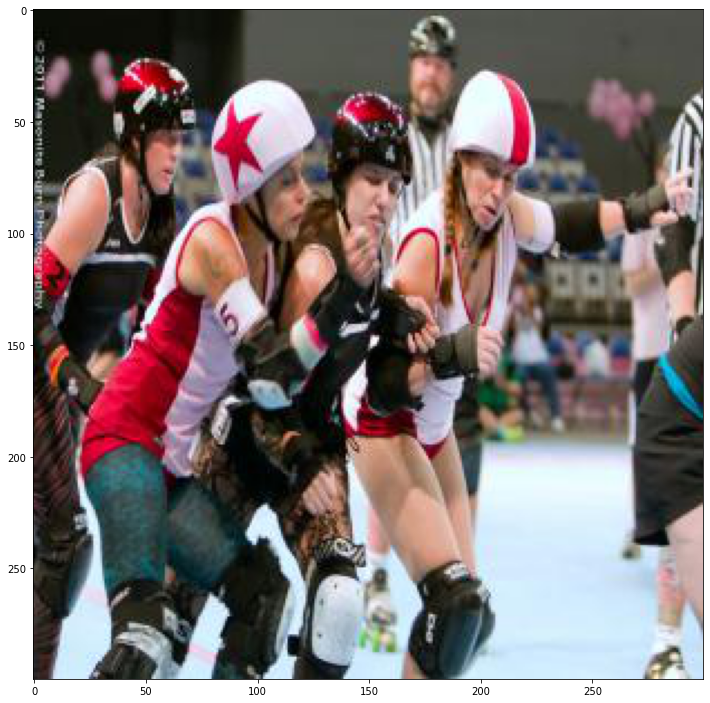

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/test/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()